# Calculate delta ERF

Here we calculate the difference in ERF between each scenario's output and what has to be run through MAGICC to get at 1.5C trajectory. We also:

- add peak warming
- add 2100 warming
- add number of years of SRM

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import scmdata
import seaborn as sns
import numpy as np
import tqdm.autonotebook as tqdman

import utils

<IPython.core.display.Javascript object>

/var/folders/2n/v3g75q4d3636klrs2jxq81zc0000gp/T/ipykernel_67536/3128152630.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [3]:
ID = "sb_noSRM_inclu"
SRM_START_YEAR = 2030
VAR = "ERF"

<IPython.core.display.Javascript object>

In [4]:
OUTPUT_DIR = Path(utils.DATA_DIR / "interim" / "delta_rf")
OUTPUT_FILE = OUTPUT_DIR / f"{ID}_delta-erf.csv"
OUTPUT_FILE_META = OUTPUT_DIR / f"{ID}_delta-erf_meta.csv"
OUTPUT_FILE.parent.parent.mkdir(exist_ok=True)
OUTPUT_FILE.parent.mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

In [5]:
ENSEMBLE_MEMBERS_15_ERF_FILE = Path(
    utils.DATA_DIR
    / "interim"
    / "merged_15_trajectories"
    / f"merged_{VAR}_{SRM_START_YEAR}.csv"
)

ERF_15 = scmdata.ScmRun(str(ENSEMBLE_MEMBERS_15_ERF_FILE))

<IPython.core.display.Javascript object>

In [6]:
MAGICC_TS_FILE = (
    utils.DATA_DIR
    / "interim"
    / "magicc-output"
    / f"magicc-output_{ID}_emission_info.csv"
)

<IPython.core.display.Javascript object>

In [7]:
magicc_output = scmdata.ScmRun(str(MAGICC_TS_FILE))
magicc_output

<ScmRun (timeseries: 416400, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	        average_annual_emissions_2030_net-zero  \
	0                                 18751.813987   
	1                                 18751.813987   
	2                                 18751.813987   
	3                                 18751.813987   
	4                                 21341.038435   
	...                                        ...   
	416395                            20076.098305   
	416396                            20076.098305   
	416397                            20076.098305   
	416398                            20076.098305   
	416399                            20076.098305   
	
	        average_cdr_between_net0_and_15 climate_model  cumulative_emms_15  \
	0                          12868.518933  MAGICCv7.5.3       -2.501199e+06   
	1                          12868.518933  MAGICCv7.5.3       -2.501199e+06   
	2                          17799.10103

<IPython.core.display.Javascript object>

## Calculate delta ERF

In [8]:
scenario_erf_ts = magicc_output.filter(variable="*Forcing*", region="World").timeseries(
    ["ensemble_member", "variable", "unit", "ms", "region"], time_axis="year"
)
ERF_15_ts = ERF_15.filter(
    region="World", ensemble_member=magicc_output.get_unique_meta("ensemble_member")
).timeseries(
    ["ensemble_member", "variable", "unit", "region", "TCRE"], time_axis="year"
)

# Rounding important
delta_rf_ts = scenario_erf_ts.round(3).subtract(ERF_15_ts, axis=0)
delta_rf_ts = delta_rf_ts.reset_index("variable")
delta_rf_ts["variable"] = "delta_rf"
delta_rf_ts = delta_rf_ts.set_index("variable", append=True)

# check that the delta is zero up to 2014
assert delta_rf_ts.loc[:, 1750:2014].max(axis=1).max() == 0.0
# display(delta_rf_ts.loc[:, 1750:2014].max(axis=1))

# add metadata back in
delta_rf_ts = delta_rf_ts.reset_index().set_index(["ms", "ensemble_member"])
meta_to_add = magicc_output.filter(
    ms=delta_rf_ts.index.get_level_values("ms").unique().tolist()
).meta.set_index(delta_rf_ts.index.names)
meta_to_add = meta_to_add[
    [c for c in meta_to_add if c not in delta_rf_ts and c not in ["run_id", "variable"]]
]

meta_to_add = meta_to_add.reset_index().drop_duplicates()
meta_to_add = meta_to_add.set_index(["ms", "ensemble_member"])


delta_rf_ts = delta_rf_ts.join(meta_to_add)

# Clip out any values less than zero
delta_rf_ts = scmdata.ScmRun(delta_rf_ts).timeseries().clip(lower=0)
delta_rf_ts = scmdata.ScmRun(delta_rf_ts)

<IPython.core.display.Javascript object>

In [9]:
# ten_ms = delta_rf_ts.get_unique_meta("ms")[::7][:10]
# ten_ms

<IPython.core.display.Javascript object>

In [10]:
# ax, lh = (
#     delta_rf_ts.filter(ms=ten_ms)
#     .drop_meta(
#         [
#             "TCRE",
#             "net_CDR_at_15_temp",
#             "year_return_back_below_15_temp",
#             "average_cdr_between_peak_and_15_temp",
#             #             "total_CDR",
#             #             "total_emissions",
#         ]
#     )
#     .plumeplot(time_axis="year", quantile_over=("ensemble_member",))
# )
# ax.legend(handles=lh, bbox_to_anchor=(1.05, 0.5), loc="center left")
# ax.set_xlim(1980, 2500)
# ax.set_ylim(-0.5, 5)
# ax.grid()

<IPython.core.display.Javascript object>

In [11]:
magicc_output = magicc_output.append(delta_rf_ts)

<IPython.core.display.Javascript object>

## Calculate peak warming

In [12]:
peak_warming = (
    magicc_output.filter(variable="Surface Air Temperature Change", region="World")
    .timeseries(["ensemble_member", "ms"], time_axis="year")
    .max(axis=1)
)
peak_warming.name = "peak_warming"
peak_warming

ensemble_member  ms                                      
0                AIM/CGE 2.1CD-LINKS_INDC2030i_1600          2.627932
                 AIM/CGE 2.1CD-LINKS_NDC2030i_1000           2.156935
                 AIM/CGE 2.2EN_INDCi2030_1000f               2.081066
                 AIM/CGE 2.2EN_INDCi2030_1200                2.094740
                 AIM/CGE 2.2EN_INDCi2030_1200f               2.159301
                                                               ...   
599              WITCH 5.0EN_INDCi2030_900_NDCp              1.918596
                 WITCH 5.0EN_INDCi2030_900f_NDCp             1.969815
                 WITCH-GLOBIOM 4.4CD-LINKS_INDC2030i_1600    1.915832
                 WITCH-GLOBIOM 4.4CD-LINKS_INDCi             4.629579
                 WITCH-GLOBIOM 4.4CD-LINKS_NDC2030i_1000     1.754784
Name: peak_warming, Length: 208200, dtype: float64

<IPython.core.display.Javascript object>

## Calculate 2100 warming

In [13]:
eoc_warming = magicc_output.filter(
    variable="Surface Air Temperature Change", region="World"
).timeseries(["ensemble_member", "ms"], time_axis="year")[2100]
eoc_warming.name = "2100_warming"
eoc_warming

ensemble_member  ms                                      
0                AIM/CGE 2.1CD-LINKS_INDC2030i_1600          2.489039
                 AIM/CGE 2.1CD-LINKS_NDC2030i_1000           2.147834
                 AIM/CGE 2.2EN_INDCi2030_1000f               1.980358
                 AIM/CGE 2.2EN_INDCi2030_1200                2.089920
                 AIM/CGE 2.2EN_INDCi2030_1200f               2.085738
                                                               ...   
599              WITCH 5.0EN_INDCi2030_900_NDCp              1.918596
                 WITCH 5.0EN_INDCi2030_900f_NDCp             1.925430
                 WITCH-GLOBIOM 4.4CD-LINKS_INDC2030i_1600    1.900094
                 WITCH-GLOBIOM 4.4CD-LINKS_INDCi             3.416044
                 WITCH-GLOBIOM 4.4CD-LINKS_NDC2030i_1000     1.605667
Name: 2100_warming, Length: 208200, dtype: float64

<IPython.core.display.Javascript object>

## Calculate 2030 warming

In [14]:
boc_warming = magicc_output.filter(
    variable="Surface Air Temperature Change", region="World"
).timeseries(["ensemble_member", "ms"], time_axis="year")[2030]
boc_warming.name = "2030_warming"
boc_warming

ensemble_member  ms                                      
0                AIM/CGE 2.1CD-LINKS_INDC2030i_1600          1.686415
                 AIM/CGE 2.1CD-LINKS_NDC2030i_1000           1.693615
                 AIM/CGE 2.2EN_INDCi2030_1000f               1.664802
                 AIM/CGE 2.2EN_INDCi2030_1200                1.664833
                 AIM/CGE 2.2EN_INDCi2030_1200f               1.664806
                                                               ...   
599              WITCH 5.0EN_INDCi2030_900_NDCp              1.574168
                 WITCH 5.0EN_INDCi2030_900f_NDCp             1.573963
                 WITCH-GLOBIOM 4.4CD-LINKS_INDC2030i_1600    1.519895
                 WITCH-GLOBIOM 4.4CD-LINKS_INDCi             1.519621
                 WITCH-GLOBIOM 4.4CD-LINKS_NDC2030i_1000     1.520148
Name: 2030_warming, Length: 208200, dtype: float64

<IPython.core.display.Javascript object>

## Calculate 2500 warming

In [19]:
eot_warming = magicc_output.filter(
    variable="Surface Air Temperature Change", region="World"
).timeseries(["ensemble_member", "ms"], time_axis="year")[2500]
eot_warming.name = "2500_warming"
eot_warming

ensemble_member  ms                                      
0                AIM/CGE 2.1CD-LINKS_INDC2030i_1600          0.357497
                 AIM/CGE 2.1CD-LINKS_NDC2030i_1000           0.855334
                 AIM/CGE 2.2EN_INDCi2030_1000f              -0.387598
                 AIM/CGE 2.2EN_INDCi2030_1200               -0.616031
                 AIM/CGE 2.2EN_INDCi2030_1200f              -0.831210
                                                               ...   
599              WITCH 5.0EN_INDCi2030_900_NDCp             -0.059801
                 WITCH 5.0EN_INDCi2030_900f_NDCp            -6.343721
                 WITCH-GLOBIOM 4.4CD-LINKS_INDC2030i_1600    0.496648
                 WITCH-GLOBIOM 4.4CD-LINKS_INDCi             0.822847
                 WITCH-GLOBIOM 4.4CD-LINKS_NDC2030i_1000    -9.247906
Name: 2500_warming, Length: 208200, dtype: float64

<IPython.core.display.Javascript object>

## Calculate SRM years

Calculate cumulative sum and then check the value in year_return_back_below_15_temp

In [15]:
srm_length_long = (
    magicc_output.filter(variable="delta_rf", region="World").timeseries(
        ["ensemble_member", "ms"], time_axis="year"
    )
    > 0
).cumsum(axis=1)

time_15 = delta_rf_ts.meta[
    ["ensemble_member", "ms", "year_return_back_below_15_temp"]
].set_index(["ensemble_member", "ms"])["year_return_back_below_15_temp"]

ms_index = list(time_15.index.names).index("ms")

srm_years = time_15 * 0
srm_years.name = "SRM_at_first_crossing"

failed_scenarios = []
for idx, year_15_row in tqdman.tqdm(time_15.items(), total=time_15.shape[0]):
    ms = idx[ms_index]

    # Scenario doesn't get back below 1.5C, srm years counted until 2500
    if year_15_row == 9999:
        srm_length = srm_length_long.loc[idx][2500]
    # Scenario doesn't overshoot 1.5C, no need for CDR: therefore undefined
    elif year_15_row == 1111:
        srm_length = 0
    else:
        try:
            srm_length = srm_length_long.loc[idx][year_15_row]
        except KeyError:
            failed_scenarios.append(ms)
    srm_years[idx] = srm_length

len(set(failed_scenarios))

  0%|          | 0/208200 [00:00<?, ?it/s]

0

<IPython.core.display.Javascript object>

In [16]:
srm_years

ensemble_member  ms                                      
0                AIM/CGE 2.1CD-LINKS_INDC2030i_1600          327
                 AIM/CGE 2.1CD-LINKS_NDC2030i_1000           309
                 AIM/CGE 2.2EN_INDCi2030_1000f               169
                 AIM/CGE 2.2EN_INDCi2030_1200                217
                 AIM/CGE 2.2EN_INDCi2030_1200f               180
                                                            ... 
599              WITCH 5.0EN_INDCi2030_900_NDCp              276
                 WITCH 5.0EN_INDCi2030_900f_NDCp             101
                 WITCH-GLOBIOM 4.4CD-LINKS_INDC2030i_1600    140
                 WITCH-GLOBIOM 4.4CD-LINKS_INDCi             374
                 WITCH-GLOBIOM 4.4CD-LINKS_NDC2030i_1000      65
Name: SRM_at_first_crossing, Length: 208200, dtype: int64

<IPython.core.display.Javascript object>

### old calculation: caused problems with pathways that reattain 1.5°C and then go back to overshooting it

In [17]:
# srm_years = (
#     magicc_output.filter(variable="delta_rf", region="World").timeseries(
#         ["ensemble_member", "ms"], time_axis="year"
#     )
#     > 0
# ).sum(axis=1)
# srm_years.name = "SRM_years"
# srm_years

<IPython.core.display.Javascript object>

### check if new calc removed this problem

In [18]:
weird = (srm_years > 300) & (
    delta_rf_ts.meta[
        ["ensemble_member", "ms", "year_return_back_below_15_temp"]
    ].set_index(["ensemble_member", "ms"])["year_return_back_below_15_temp"]
    < 2160
)
assert not weird.any(), "Must be something wrong somewhere..."

<IPython.core.display.Javascript object>

In [19]:
weird[weird]

Series([], dtype: bool)

<IPython.core.display.Javascript object>

## Join, remove no_SRM and longer than 2500 SRM scenarios, then save

In [20]:
out_run = scmdata.ScmRun(
    magicc_output.timeseries()
    .join(peak_warming)
    .join(srm_years)
    .join(eoc_warming)
    .join(boc_warming)
    .join(eot_warming)
)

<IPython.core.display.Javascript object>

In [21]:
## remove all scenarios that don't have SRM or that have SRM deployment longer than 2500

# out_run = out_run[
#     (out_run["year_return_back_below_15_temp"] < 2501)
#     & (out_run["year_return_back_below_15_temp"] > 2029)
# ]

<IPython.core.display.Javascript object>

In [21]:
print("Saving meta")
out_run.meta.to_csv(str(OUTPUT_FILE_META), index=False)
#out_run.meta.to_csv(str(OUTPUT_FILE_META), index=False)

print("Saving full set")
out_run.to_csv(str(OUTPUT_FILE))
#out_run.to_csv(str(OUTPUT_FILE))


Saving meta
Saving full set


<IPython.core.display.Javascript object>

## Quick plots

In [26]:
srm_years_pdf = out_run.meta[  # .filter(ms=ten_ms)
    ["SRM_years", "ms", "ensemble_member", "year_return_back_below_15_temp"]
].drop_duplicates()
display(srm_years_pdf.head())

,SRM_years,ms,ensemble_member,year_return_back_below_15_temp
0,327,AIM/CGE 2.1CD-LINKS_INDC2030i_1600,0,2382
3,309,AIM/CGE 2.1CD-LINKS_NDC2030i_1000,0,2364
6,169,AIM/CGE 2.2EN_INDCi2030_1000f,0,2213
9,217,AIM/CGE 2.2EN_INDCi2030_1200,0,2260
12,180,AIM/CGE 2.2EN_INDCi2030_1200f,0,2224


<IPython.core.display.Javascript object>

In [27]:
SRM_depl = srm_years_pdf[
    (srm_years_pdf["year_return_back_below_15_temp"] < 2501)
    & (srm_years_pdf["year_return_back_below_15_temp"] > 2029)
]
noSRM_depl = srm_years_pdf[(srm_years_pdf["year_return_back_below_15_temp"] == 2029)]
longSRM_depl = srm_years_pdf[(srm_years_pdf["year_return_back_below_15_temp"] == 2501)]

<IPython.core.display.Javascript object>

In [28]:
SRM_depl.describe()

,SRM_years,ensemble_member,year_return_back_below_15_temp
count,166210.000000,166210.000000,166210.00000
mean,168.308850,302.657060,2219.13667
std,105.877108,172.195628,112.96370
min,0.000000,0.000000,2036.00000
25%,84.000000,154.000000,2128.00000
50%,145.000000,304.000000,2194.00000
75%,240.000000,453.000000,2295.00000
max,469.000000,599.000000,2500.00000


<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


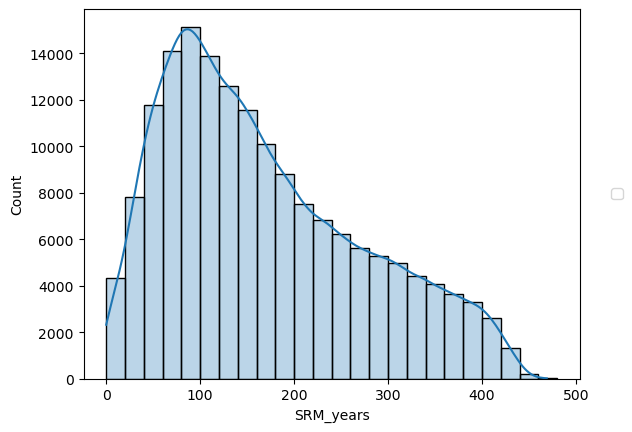

<IPython.core.display.Javascript object>

In [30]:
ax = sns.histplot(
    data=SRM_depl,
    x="SRM_years",
    #  hue="ms",
    bins=range(0, 500, 20),
    kde=True,
    #     element="step",
    #     multiple="stack",
    alpha=0.3,
)
ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'REMIND 1.7ADVANCE_2030_Price1.5C'),
  Text(1, 0, 'WITCH-GLOBIOM 4.4CD-LINKS_NDC2030i_1000'),
  Text(2, 0, 'REMIND-MAgPIE 2.1-4.2EN_INDCi2030_600f_COV_NDCp'),
  Text(3, 0, 'REMIND-MAgPIE 1.7-3.0PEP_1p5C_full_NDC'),
  Text(4, 0, 'WITCH 5.0EN_INDCi2030_500f'),
  Text(5, 0, 'MESSAGEix-GLOBIOM_1.1EN_INDCi2030_950f_COV'),
  Text(6, 0, 'POLES ADVANCEADVANCE_2030_Price1.5C'),
  Text(7, 0, 'REMIND 1.7ADVANCE_2030_Med2C'),
  Text(8, 0, 'POLES ADVANCEADVANCE_2030_1.5C-2100'),
  Text(9, 0, 'COFFEE 1.1EN_INDCi2030_400f')])

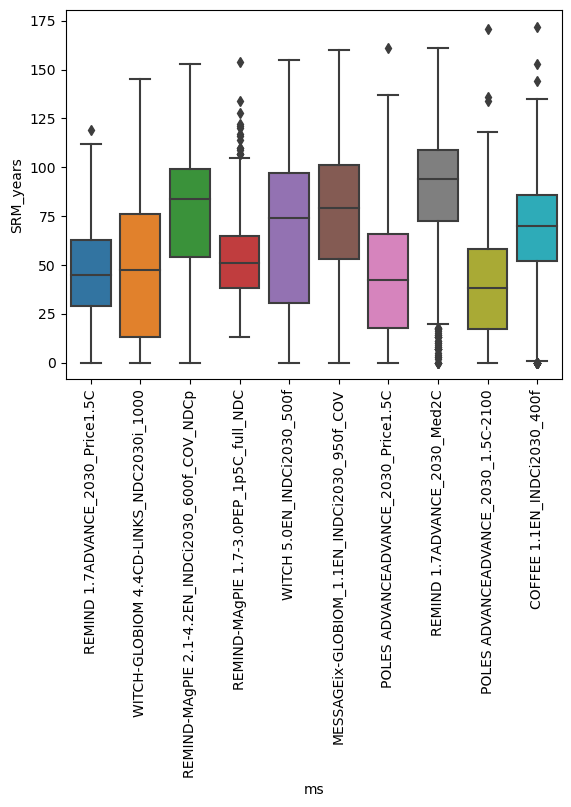

<IPython.core.display.Javascript object>

In [24]:
min_ten_ms = (
    out_run.meta[["SRM_years", "ms", "ensemble_member"]]
    .drop_duplicates()
    .groupby("ms")["SRM_years"]
    .max()
    .sort_values()
    .index[:10]
)

srm_years_pdf = (
    out_run.filter(ms=min_ten_ms)
    .meta[["SRM_years", "ms", "ensemble_member"]]
    .drop_duplicates()
)

ax = sns.boxplot(data=srm_years_pdf, y="SRM_years", x="ms", order=min_ten_ms)
plt.xticks(rotation=90)

In [25]:
# ax = sns.stripplot(
#     data=srm_years_pdf, y="SRM_years", hue="ms", x="ensemble_member", legend=False
# )
# # ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")

<IPython.core.display.Javascript object>

In [26]:
# ax = sns.stripplot(data=srm_years_pdf, y="SRM_years", x="ms", hue="ensemble_member")
# ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
# plt.xticks(rotation=90)

<IPython.core.display.Javascript object>

In [27]:
# ax = sns.boxplot(data=srm_years_pdf, y="SRM_years", x="ms")
# # ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
# plt.xticks(rotation=90)

<IPython.core.display.Javascript object>